# Battle of Neighbourhoods - Final Capstone project
##  Where to locate a new Indian restaurant in Mumbai
In this project we will look at the various venues in a given ward in Mumbai and try to find the most suitable ward to open a new Indian restaurant

### Import the relevant libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Get the Data
### Read in the BMC_Wards.geojson which has the geometry of the various municipal wards in Mumbai

In [25]:
with open('BMC_Wards.geojson') as json_data:
    mumbai_geojson = json.load(json_data)

### Investigate to find the various properties

In [26]:
mumbai_geojson

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'gid': 1, 'name': 'A'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[72.840253948166, 18.94880846402114],
       [72.84030270105343, 18.948804332423883],
       [72.8404167086157, 18.948830795037264],
       [72.84042772265047, 18.94883335134029],
       [72.84054906348473, 18.948861516161077],
       [72.84059164031676, 18.948871398026178],
       [72.84065147596793, 18.94888528730686],
       [72.84066545245484, 18.94888853116952],
       [72.84070090306439, 18.948894125295443],
       [72.84083049933672, 18.94891457291972],
       [72.84096878649683, 18.94893639160987],
       [72.84124619023915, 18.948980160362634],
       [72.84135278958591, 18.948992325083825],
       [72.84137756589088, 18.948995152716925],
       [72.84150367087838, 18.948991194539587],
       [72.84157947398036, 18.9489359918313

### The 'features' item contains the ward id and the geometry
### Extract the features portion and examine the 1st element

In [27]:
mumbai_featuers = mumbai_geojson['features']
mumbai_featuers[0]

{'type': 'Feature',
 'properties': {'gid': 1, 'name': 'A'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[72.840253948166, 18.94880846402114],
     [72.84030270105343, 18.948804332423883],
     [72.8404167086157, 18.948830795037264],
     [72.84042772265047, 18.94883335134029],
     [72.84054906348473, 18.948861516161077],
     [72.84059164031676, 18.948871398026178],
     [72.84065147596793, 18.94888528730686],
     [72.84066545245484, 18.94888853116952],
     [72.84070090306439, 18.948894125295443],
     [72.84083049933672, 18.94891457291972],
     [72.84096878649683, 18.94893639160987],
     [72.84124619023915, 18.948980160362634],
     [72.84135278958591, 18.948992325083825],
     [72.84137756589088, 18.948995152716925],
     [72.84150367087838, 18.948991194539587],
     [72.84157947398036, 18.948935991831398],
     [72.84163321971066, 18.948935957424613],
     [72.84163391270842, 18.948935956461963],
     [72.84168835144983, 18.948935920173373],
     [72.8417420772629

### Get the coordinates of the 1st element and gets it shape

In [28]:
coordinates = np.array(mumbai_featuers[0]['geometry']['coordinates'])
print(coordinates)
coordinates.shape

[[[[72.84025395 18.94880846]
   [72.8403027  18.94880433]
   [72.84041671 18.9488308 ]
   ...
   [72.84021008 18.94881963]
   [72.84021665 18.94881163]
   [72.84025395 18.94880846]]]]


(1, 1, 1867, 2)

### The main vertices of the polygon are in the 3rd and 4th dimension
### Extract that for the 1st emement
### and get the mean to get the center of the 1st ward

In [29]:
coordinates[0][0].mean(axis=0)

array([72.82747151, 18.9209813 ])

In [30]:
# define the dataframe columns
column_names = ['Ward', 'Latitude', 'Longitude'] 

# instantiate the dataframe
wards = pd.DataFrame(columns=column_names)

In [31]:
wards

,Ward,Latitude,Longitude


In [32]:
for data in mumbai_featuers:
    ward_name = data['properties']['name']
    coordinates = data['geometry']['coordinates']
    means = np.array(coordinates[0][0])
    means=means.mean(axis=0)
    # Get the longitude and latitude
    ward_lon, ward_lat = means
    wards = wards.append({'Ward': ward_name,
                                          'Latitude': ward_lat,
                                          'Longitude': ward_lon}, ignore_index=True)

In [33]:
wards

,Ward,Latitude,Longitude
0,A,18.920981,72.827472
1,B,18.956941,72.839720
2,C,18.951097,72.827200
3,D,18.955231,72.808287
4,E,18.973439,72.843214
5,F/S,18.998980,72.853965
6,G/S,19.004169,72.820140
7,F/N,19.031895,72.870740
8,G/N,19.030693,72.844038
9,N,19.086679,72.920185


### replace the /S with ' South' and so forth

In [34]:
wards['Ward'] = wards['Ward'].str.replace('/S', ' South')
wards['Ward'] = wards['Ward'].str.replace('/N', ' North')
wards['Ward'] = wards['Ward'].str.replace('/W', ' West')
wards['Ward'] = wards['Ward'].str.replace('/E', ' East')
wards['Ward'] = wards['Ward'].str.replace('/C', ' Central')
wards

,Ward,Latitude,Longitude
0,A,18.920981,72.827472
1,B,18.956941,72.839720
2,C,18.951097,72.827200
3,D,18.955231,72.808287
4,E,18.973439,72.843214
5,F South,18.998980,72.853965
6,G South,19.004169,72.820140
7,F North,19.031895,72.870740
8,G North,19.030693,72.844038
9,N,19.086679,72.920185


### The get the area names for the wards read in the csv file with wards id and name

In [181]:
wardarea = pd.read_csv("wardareaname.csv")
wardarea.head(10)

,Ward,Area
0,A,Colaba
1,B,Sanhurst Road
2,C,Marine Lines
3,D,Grant Road
4,E,Byculla
5,F South,Parel
6,F North,Matunga
7,G South,Elphinstone
8,G North,Dadar/Plaza
9,H East,Khar/Santacruz


In [36]:
wardarealatlong = wardarea.merge(wards, on='Ward')
wardarealatlong

,Ward,Area,Latitude,Longitude
0,A,Colaba,18.920981,72.827472
1,B,Sanhurst Road,18.956941,72.839720
2,C,Marine Lines,18.951097,72.827200
3,D,Grant Road,18.955231,72.808287
4,E,Byculla,18.973439,72.843214
5,F South,Parel,18.998980,72.853965
6,F North,Matunga,19.031895,72.870740
7,G South,Elphinstone,19.004169,72.820140
8,G North,Dadar/Plaza,19.030693,72.844038
9,H East,Khar/Santacruz,19.077906,72.859472


### concatenat Ward  id and area name and create a new data frame along with latitude and longitude

In [47]:
# get concatenated data
wardname = 'Ward '+wardarealatlong['Ward']+' - '+wardarealatlong['Area']
wardname

0                    Ward A - Colaba
1             Ward B - Sanhurst Road
2              Ward C - Marine Lines
3                Ward D - Grant Road
4                   Ward E - Byculla
5               Ward F South - Parel
6             Ward F North - Matunga
7         Ward G South - Elphinstone
8         Ward G North - Dadar/Plaza
9       Ward H East - Khar/Santacruz
10              Ward H West - Bandra
11      Ward K East - Andheri (East)
12      Ward K West - Andheri (West)
13                    Ward L - Kurla
14        Ward M East - Chembur East
15        Ward M West - Chembur West
16                Ward N - Ghatkopar
17           Ward P South - Goregaon
18              Ward P North - Malad
19         Ward R South - Kandivalli
20    Ward R Central - Borivali West
21            Ward R North - Dahiser
22                  Ward S - Bhandup
23                   Ward T - Mulund
dtype: object

In [144]:
# Create a new dataframe
mumbai_data = pd.DataFrame({'WardArea': wardname, 'Latitude': wardarealatlong['Latitude'], 'Longitude': wardarealatlong['Longitude']})
mumbai_data

,WardArea,Latitude,Longitude
0,Ward A - Colaba,18.920981,72.827472
1,Ward B - Sanhurst Road,18.956941,72.839720
2,Ward C - Marine Lines,18.951097,72.827200
3,Ward D - Grant Road,18.955231,72.808287
4,Ward E - Byculla,18.973439,72.843214
5,Ward F South - Parel,18.998980,72.853965
6,Ward F North - Matunga,19.031895,72.870740
7,Ward G South - Elphinstone,19.004169,72.820140
8,Ward G North - Dadar/Plaza,19.030693,72.844038
9,Ward H East - Khar/Santacruz,19.077906,72.859472


In [145]:
# for mumbai center takee the mean loaction of all wards so that map is centered properly
latitude = wards['Latitude'].mean()
longitude = wards['Longitude'].mean()
print('The geograpical coordinate of Mumbai City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai City are 19.07505712563969, 72.85810027636394.


### Visualize the wards on map

In [146]:
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(mumbai_data['Latitude'], mumbai_data['Longitude'],mumbai_data['WardArea']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai


### Set up the foursquare parameters and get the nearby venues for each ward

In [54]:
CLIENT_ID = 'DWEXM50DMIASXE1ICCHVYPI04OUZVWWERCNWTLAXFKWFTLIP' # your Foursquare ID
CLIENT_SECRET = 'HWYPBBRK1N5R2XT3BCXDPKZQAXMYU4VSWUE23Q2LO4HASPZP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT=100

In [55]:
#function to get the nearby venues for a given latitude and longitude within a specified radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        urljson = requests.get(url).json()
        print(urljson["response"])
        results = urljson["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
mumbai_venues = getNearbyVenues(names=mumbai_data['WardArea'],
                                   latitudes=mumbai_data['Latitude'],
                                   longitudes=mumbai_data['Longitude']
                                  )



Ward A - Colaba
{'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 34, 'suggestedBounds': {'ne': {'lat': 18.925481307166525, 'lng': 72.83221966743481}, 'sw': {'lat': 18.916481298166513, 'lng': 72.8227233446243}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b1145fff964a520937923e3', 'name': 'Theobroma', 'location': {'address': 'Shop 24, Cusrow Baug, Colaba Causeway', 'crossStreet': 'Shahid Bhagat Singh Road', 'lat': 18.91929830684632, 'lng': 72.82918453216553, 'labeledLatLngs': [{'label': 'display', 'lat': 18.91929830684632, 'lng': 72.82918453216553}], 'distance': 260, 'postalCode': '400005', 'cc': 'IN', 'neighborhood': 'Colaba', 'city': 'Mumbai'

{'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 7, 'suggestedBounds': {'ne': {'lat': 18.961440729565687, 'lng': 72.84446885090743}, 'sw': {'lat': 18.952440720565676, 'lng': 72.83497048278694}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4da82ee86a2364c7a34db978', 'name': 'Le Mill', 'location': {'lat': 18.957378865718038, 'lng': 72.8407423537711, 'labeledLatLngs': [{'label': 'display', 'lat': 18.957378865718038, 'lng': 72.8407423537711}], 'distance': 118, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1f8941735', 'name': 'Furniture / Home Store', 'pluralName': 'Furniture / Home Stores', 'shortName': 'Furniture / Home', 'ic

{'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Malabar Hill', 'headerFullLocation': 'Malabar Hill, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 15, 'suggestedBounds': {'ne': {'lat': 18.959731343562197, 'lng': 72.81303577048816}, 'sw': {'lat': 18.950731334562185, 'lng': 72.80353749969926}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cd194c801eaf04d9122bf5d', 'name': 'Soam', 'location': {'address': '3 Sadguru Sadan, opp. Babulnath Temple, Girgaum Chowpatty,', 'lat': 18.957492031614574, 'lng': 72.80888354503129, 'labeledLatLngs': [{'label': 'display', 'lat': 18.957492031614574, 'lng': 72.80888354503129}], 'distance': 259, 'postalCode': '400007', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': '

{'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 4, 'suggestedBounds': {'ne': {'lat': 18.977939086007094, 'lng': 72.84796371105988}, 'sw': {'lat': 18.968939077007082, 'lng': 72.83846440299412}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e928eda55037de99d6d9696', 'name': 'Gupta ice cream', 'location': {'address': '103 A/B Mount To ad', 'crossStreet': 'Anjirwadi, Mazgaon', 'lat': 18.973559220847054, 'lng': 72.84022215304088, 'labeledLatLngs': [{'label': 'display', 'lat': 18.973559220847054, 'lng': 72.84022215304088}], 'distance': 315, 'postalCode': '400010', 'cc': 'IN', 'city': 'mumbai', 'state': 'maharshtra', 'country': 'India', 'formattedAddress': ['103 A/B Mount To ad (Anjirwadi, Mazgaon)', 'mumbai 400010', 'maharshtra', 'India']}, 'catego

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 1, 'suggestedBounds': {'ne': {'lat': 19.03639489755815, 'lng': 72.87549179412747}, 'sw': {'lat': 19.02739488855814, 'lng': 72.86598914787294}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4fcf65bee4b0dd1e7cee0b1d', 'name': "Domino's Pizza", 'location': {'address': 'GROUND FLOOR,SHOP NO-A14 & A-15A-2, WING D & E,C.S.NO 85-93SALT PAN DIVISION, KALPAK ESTATE, S.M. ROADANTOP HILL,WADALA,MUMBAI', 'lat': 19.03, 'lng': 72.867, 'labeledLatLngs': [{'label': 'display', 'lat': 19.03, 'lng': 72.867}], 'distance': 446, 'postalCode': '400037', 'cc': 'IN', 'city': 'Mumbai',

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 3, 'suggestedBounds': {'ne': {'lat': 19.0824063213448, 'lng': 72.86422438456823}, 'sw': {'lat': 19.073406312344787, 'lng': 72.85471910216499}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ccc2f76566aa0931aa61ffd', 'name': "Natural's Ice Cream", 'location': {'address': '#3 Gokul Harmony', 'crossStreet': 'Kalina Market, Santacruz', 'lat': 19.07755998111434, 'lng': 72.8630348274812, 'labeledLatLngs': [{'label': 'display', 'lat': 19.07755998111434, 'lng': 72.8630348274812}], 'distance': 376, 'postalCode': '400098', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārās

{'headerLocation': 'Jogeshwari East', 'headerFullLocation': 'Jogeshwari East, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 10, 'suggestedBounds': {'ne': {'lat': 19.116684073748115, 'lng': 72.8740392736797}, 'sw': {'lat': 19.107684064748103, 'lng': 72.86453202245215}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d19939f6c8b548106c0f9cc', 'name': 'Spirit Kitchen and Bar', 'location': {'address': 'Mathuradas Vasanji Rd, MIDC Industrial Estate, And', 'lat': 19.11125788546854, 'lng': 72.86982004017375, 'labeledLatLngs': [{'label': 'display', 'lat': 19.11125788546854, 'lng': 72.86982004017375}], 'distance': 117, 'postalCode': '400057', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Mathuradas Vasanji Rd, MIDC Industrial Estate, And', 'Mumb

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Current map view', 'headerFullLocation': 'Current map view', 'headerLocationGranularity': 'unknown', 'totalResults': 0, 'suggestedBounds': {'ne': {'lat': 19.13809402782975, 'lng': 72.78665153670676}, 'sw': {'lat': 19.12909401882974, 'lng': 72.77714305360672}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': []}]}
Ward L - Kurla
{'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Mumbai', 'headerFullLocation': 'Mumbai', 'headerLocationGranularity': 'city', 'totalResults': 52, 'suggestedBounds': {'ne': {'lat': 19.092301332792257, 'lng': 72.89017162796564}, 'sw': {'lat': 19.083301323792245, 'lng': 72.88066577765188}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': '

{'headerLocation': 'Govandi', 'headerFullLocation': 'Govandi, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 4, 'suggestedBounds': {'ne': {'lat': 19.049299978771725, 'lng': 72.92635808265356}, 'sw': {'lat': 19.040299969771713, 'lng': 72.9168546977896}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5242954c498eb6952d2879a6', 'name': 'Cafe Coffee Day', 'location': {'address': 'Deonar', 'lat': 19.04462515794868, 'lng': 72.91790806103137, 'labeledLatLngs': [{'label': 'display', 'lat': 19.04462515794868, 'lng': 72.91790806103137}], 'distance': 389, 'cc': 'IN', 'country': 'India', 'formattedAddress': ['Deonar', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/

{'headerLocation': 'Goregaon', 'headerFullLocation': 'Goregaon, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 7, 'suggestedBounds': {'ne': {'lat': 19.161993993121705, 'lng': 72.86314787574553}, 'sw': {'lat': 19.152993984121693, 'lng': 72.85363801555842}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cb35bedc5e6a1cd592fecf6', 'name': "McDonald's", 'location': {'address': 'Western Express Hwy.', 'lat': 19.154510917747306, 'lng': 72.85646222090531, 'labeledLatLngs': [{'label': 'display', 'lat': 19.154510917747306, 'lng': 72.85646222090531}], 'distance': 389, 'postalCode': '400065', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Western Express Hwy.', 'Mumbai 400065', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d16e94173

{'headerLocation': 'Kandivali West', 'headerFullLocation': 'Kandivali West, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 5, 'suggestedBounds': {'ne': {'lat': 19.204133412067137, 'lng': 72.86092208440094}, 'sw': {'lat': 19.195133403067125, 'lng': 72.85140979118692}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e30f62818380c94aca64f93', 'name': 'V K Snacks', 'location': {'address': 'Shop No - 4, Sai Arman Building', 'crossStreet': 'Ashok Chakravarti Road. Ashok Nagar', 'lat': 19.19888497325031, 'lng': 72.85692212956369, 'labeledLatLngs': [{'label': 'display', 'lat': 19.19888497325031, 'lng': 72.85692212956369}], 'distance': 115, 'postalCode': '400101', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Shop No - 4, Sai Arman Building (Asho

{'headerLocation': 'Dahisar East', 'headerFullLocation': 'Dahisar East, Mumbai', 'headerLocationGranularity': 'neighborhood', 'totalResults': 7, 'suggestedBounds': {'ne': {'lat': 19.259783463146007, 'lng': 72.87110486631123}, 'sw': {'lat': 19.250783454145996, 'lng': 72.8615893502017}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f9d5b91e4b0e9595bbd63c0', 'name': 'Kamdar Chinese Center', 'location': {'address': 'near dahisar petrol pump', 'crossStreet': 's v road', 'lat': 19.253762309969986, 'lng': 72.86600869562531, 'labeledLatLngs': [{'label': 'display', 'lat': 19.253762309969986, 'lng': 72.86600869562531}], 'distance': 173, 'postalCode': '400068', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['near dahisar petrol pump (s v road)', 'Mumbai 400068', 'Mahārās

In [148]:
print(mumbai_venues.shape)
mumbai_venues.head()

(338, 7)


,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ward A - Colaba,18.920981,72.827472,Theobroma,18.919298,72.829185,Dessert Shop
1,Ward A - Colaba,18.920981,72.827472,New Martin,18.918624,72.829512,Indian Restaurant
2,Ward A - Colaba,18.920981,72.827472,Mad Over Donuts,18.919209,72.829427,Donut Shop
3,Ward A - Colaba,18.920981,72.827472,Café Basilico,18.918609,72.830484,Diner
4,Ward A - Colaba,18.920981,72.827472,Piccadilly,18.921425,72.830936,Falafel Restaurant


## Explore the Data

In [149]:
# get the venue counts in each ward
mumbai_venues.groupby('Ward').count()

,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Ward,,,,,,
Ward A - Colaba,34,34,34,34,34,34
Ward B - Sanhurst Road,7,7,7,7,7,7
Ward C - Marine Lines,9,9,9,9,9,9
Ward D - Grant Road,15,15,15,15,15,15
Ward E - Byculla,4,4,4,4,4,4
Ward F North - Matunga,1,1,1,1,1,1
Ward F South - Parel,6,6,6,6,6,6
Ward G North - Dadar/Plaza,21,21,21,21,21,21
Ward G South - Elphinstone,4,4,4,4,4,4


In [102]:
# number of unique categories
print('There are {} uniques categories.'.format(len(mumbai_venues['Venue Category'].unique())))

There are 97 uniques categories.


### One hot encoding of the venues

In [151]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Ward'] = mumbai_venues['Ward'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Lodge,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Ward A - Colaba,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ward A - Colaba,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ward A - Colaba,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ward A - Colaba,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ward A - Colaba,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [152]:
mumbai_onehot.shape

(338, 98)

In [153]:
# group by ward get the mean for each type of venue
mumbai_grouped = mumbai_onehot.groupby('Ward').mean().reset_index()
mumbai_grouped

,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Lodge,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Ward A - Colaba,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.117647,0.029412,0.029412,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.088235,0.029412,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.0,0.000000,0.147059,0.000000,0.000000,0.029412,0.00,0.029412,0.029412,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ward B - Sanhurst Road,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0,0.000000,0.285714,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ward C - Marine Lines,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.111111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
3,Ward D - Grant Road,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0

In [154]:
mumbai_grouped.shape

(22, 98)

### there are only 22 wards here ... so 2 wards did not get any venues

In [155]:
# Get the frequency of the venus and sort it by top venues for each ward
num_top_venues = 5

for hood in mumbai_grouped['Ward']:
    print("----"+hood+"----")
    temp = mumbai_grouped[mumbai_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ward A - Colaba----
               venue  freq
0  Indian Restaurant  0.15
1               Café  0.12
2              Diner  0.09
3        Coffee Shop  0.06
4  German Restaurant  0.03


----Ward B - Sanhurst Road----
                    venue  freq
0       Indian Restaurant  0.29
1       Convenience Store  0.14
2         Harbor / Marina  0.14
3  Furniture / Home Store  0.14
4          Sandwich Place  0.14


----Ward C - Marine Lines----
               venue  freq
0  Indian Restaurant  0.33
1      Women's Store  0.11
2          Multiplex  0.11
3               Food  0.11
4        Bus Station  0.11


----Ward D - Grant Road----
               venue  freq
0  Indian Restaurant  0.40
1        Coffee Shop  0.13
2               Park  0.07
3          Gastropub  0.07
4            Theater  0.07


----Ward E - Byculla----
                 venue  freq
0   Chinese Restaurant  0.25
1       Ice Cream Shop  0.25
2    Indian Restaurant  0.25
3         Dessert Shop  0.25
4  American Restaurant  0.00




In [108]:
# Function to return the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Get the top 10 venues

In [156]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ward'] = mumbai_grouped['Ward']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ward A - Colaba,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
1,Ward B - Sanhurst Road,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,Ward C - Marine Lines,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,Ward D - Grant Road,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
4,Ward E - Byculla,Chinese Restaurant,Dessert Shop,Ice Cream Shop,Indian Restaurant,Women's Store,Donut Shop,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega


### for clustering find the optiman cluster count

In [157]:
mumbai_grouped_clustering = mumbai_grouped.drop('Ward', 1)
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(n_clusters=n, random_state=0).fit(mumbai_grouped_clustering)
    mean_acc[n-1] = kmeans.inertia_   #kmeans.score(mumbai_grouped_clustering)

 
mean_acc

array([4.2421665 , 3.24190189, 2.29023756, 2.08299858, 1.74573939,
       1.55026719, 1.31842815, 1.19761801, 0.97524003])

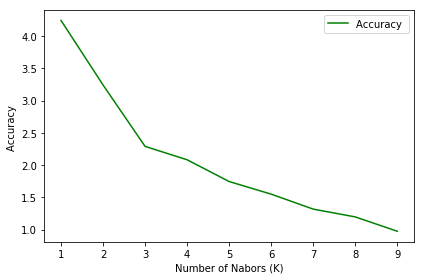

In [158]:
plt.plot(range(1,Ks),mean_acc,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [159]:
# set number of clusters to 5 based on elbow
kclusters = 5

mumbai_grouped_clustering = mumbai_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 3, 2, 0, 0, 4, 3])

In [161]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [162]:
#print(mumbai_merged['Cluster Labels'], neighborhoods_venues_sorted['Ward'], neighborhoods['Ward'])
mumbai_merged = mumbai_data

# merge mumbai_grouped with mumbai_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(neighborhoods_venues_sorted.set_index('Ward'), on='WardArea')
mumbai_merged.dropna(axis=0, inplace=True)
#print(mumbai_merged['Cluster Labels'])
mumbai_merged['Cluster Labels'] = mumbai_merged['Cluster Labels'].astype(int)
mumbai_merged.head() # check the last columns!

,WardArea,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ward A - Colaba,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
1,Ward B - Sanhurst Road,18.956941,72.839720,0,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,Ward C - Marine Lines,18.951097,72.827200,0,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,Ward D - Grant Road,18.955231,72.808287,0,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
4,Ward E - Byculla,18.973439,72.843214,3,Chinese Restaurant,Dessert Shop,Ice Cream Shop,Indian Restaurant,Women's Store,Donut Shop,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega


In [163]:
mumbai_merged.shape

(22, 14)

In [164]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['WardArea'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Investigating the Clusters

### Cluster 0 - a Major group

In [165]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ward A - Colaba,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
1,Ward B - Sanhurst Road,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,Ward C - Marine Lines,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,Ward D - Grant Road,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
5,Ward F South - Parel,Bus Station,Train Station,Harbor / Marina,Flea Market,Breakfast Spot,Women's Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
8,Ward G North - Dadar/Plaza,Indian Restaurant,Movie Theater,Chinese Restaurant,Fast Food Restaurant,Department Store,Deli / Bodega,Beach,Bar,Sandwich Place,Fish Market
10,Ward H West - Bandra,Indian Restaurant,Café,Chinese Restaurant,Dessert Shop,Gym / Fitness Center,Arcade,Asian Restaurant,Bakery,Bar,Bookstore
11,Ward K East - Andheri (East),Hotel,Indian Restaurant,Multiplex,Vegetarian / Vegan Restaurant,Pizza Place,Department Store,Hotel Bar,Burger Joint,Diner,Cosmetics Shop
13,Ward L - Kurla,Café,Indian Restaurant,Coffee Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Restaurant,Dessert Shop,Beer Garden,Shopping Mall
14,Ward M East - Chembur East,Coffee Shop,Indian Restaurant,Café,Convenience Store,Food & Drink Shop,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio,French Restaurant


### Cluster 1 - Beach and tourist shopping

In [166]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Ward M West - Chembur West,Beach,Women's Store,Electronics Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


### Cluster 2 - Snack zone

In [167]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Ward F North - Matunga,Pizza Place,Women's Store,Donut Shop,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop


### Cluster 3 - Eateries

In [169]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Ward E - Byculla,Chinese Restaurant,Dessert Shop,Ice Cream Shop,Indian Restaurant,Women's Store,Donut Shop,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega
9,Ward H East - Khar/Santacruz,Bar,Ice Cream Shop,Indian Restaurant,Women's Store,Electronics Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store


### Cluster 4 - Tourist zone

In [170]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[0] + list(range(4, mumbai_merged.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Ward G South - Elphinstone,Art Gallery,Pizza Place,Thai Restaurant,Lounge,Women's Store,Donut Shop,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega


## Take up Cluster 0 for reclustering

In [171]:
mumbai_sub = mumbai_merged[mumbai_merged['Cluster Labels'] == 0].copy()
mumbai_sub

,WardArea,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ward A - Colaba,18.920981,72.827472,0,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
1,Ward B - Sanhurst Road,18.956941,72.839720,0,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,Ward C - Marine Lines,18.951097,72.827200,0,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,Ward D - Grant Road,18.955231,72.808287,0,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
5,Ward F South - Parel,18.998980,72.853965,0,Bus Station,Train Station,Harbor / Marina,Flea Market,Breakfast Spot,Women's Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
8,Ward G North - Dadar/Plaza,19.030693,72.844038,0,Indian Restaurant,Movie Theater,Chinese Restaurant,Fast Food Restaurant,Department Store,Deli / Bodega,Beach,Bar,Sandwich Place,Fish Market
10,Ward H West - Bandra,19.062199,72.828466,0,Indian Restaurant,Café,Chinese Restaurant,Dessert Shop,Gym / Fitness Center,Arcade,Asian Restaurant,Bakery,Bar,Bookstore
11,Ward K East - Andheri (East),19.112184,72.869286,0,Hotel,Indian Restaurant,Multiplex,Vegetarian / Vegan Restaurant,Pizza Place,Department Store,Hotel Bar,Burger Joint,Diner,Cosmetics Shop
13,Ward L - Kurla,19.087801,72.885419,0,Café,Indian Restaurant,Coffee Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Restaurant,Dessert Shop,Beer Garden,Shopping Mall
14,Ward M East - Chembur East,19.044800,72.921606,0,Coffee Shop,Indian Restaurant,Café,Convenience Store,Food & Drink Shop,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio,French Restaurant


In [172]:
# drop the cluster numbering from previous cycle
mumbai_sub.drop('Cluster Labels', axis=1, inplace=True)
mumbai_sub

,WardArea,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ward A - Colaba,18.920981,72.827472,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
1,Ward B - Sanhurst Road,18.956941,72.839720,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,Ward C - Marine Lines,18.951097,72.827200,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,Ward D - Grant Road,18.955231,72.808287,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
5,Ward F South - Parel,18.998980,72.853965,Bus Station,Train Station,Harbor / Marina,Flea Market,Breakfast Spot,Women's Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
8,Ward G North - Dadar/Plaza,19.030693,72.844038,Indian Restaurant,Movie Theater,Chinese Restaurant,Fast Food Restaurant,Department Store,Deli / Bodega,Beach,Bar,Sandwich Place,Fish Market
10,Ward H West - Bandra,19.062199,72.828466,Indian Restaurant,Café,Chinese Restaurant,Dessert Shop,Gym / Fitness Center,Arcade,Asian Restaurant,Bakery,Bar,Bookstore
11,Ward K East - Andheri (East),19.112184,72.869286,Hotel,Indian Restaurant,Multiplex,Vegetarian / Vegan Restaurant,Pizza Place,Department Store,Hotel Bar,Burger Joint,Diner,Cosmetics Shop
13,Ward L - Kurla,19.087801,72.885419,Café,Indian Restaurant,Coffee Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Restaurant,Dessert Shop,Beer Garden,Shopping Mall
14,Ward M East - Chembur East,19.044800,72.921606,Coffee Shop,Indian Restaurant,Café,Convenience Store,Food & Drink Shop,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio,French Restaurant


### Extract cluster 0 of prev cycle from grouped data

In [173]:
# add clustering labels the grouped data
mumbai_grouped.insert(1, 'Cluster Labels', kmeans.labels_)
mumbai_grouped

,Ward,Cluster Labels,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Lodge,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Ward A - Colaba,0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.117647,0.029412,0.029412,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.088235,0.029412,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.0,0.000000,0.147059,0.000000,0.000000,0.029412,0.00,0.029412,0.029412,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ward B - Sanhurst Road,0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0,0.000000,0.285714,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ward C - Marine Lines,0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.111111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
3,Ward D - Grant Road,0,0.000000,0.000000,0.00,0.000000,0.000000,0

In [174]:
mumbai_sub_grouped = mumbai_grouped[mumbai_grouped['Cluster Labels'] == 0].copy()
mumbai_sub_grouped

,Ward,Cluster Labels,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Lodge,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Ward A - Colaba,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.117647,0.029412,0.029412,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.088235,0.029412,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.0,0.000000,0.147059,0.000000,0.000000,0.029412,0.00,0.029412,0.029412,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ward B - Sanhurst Road,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0,0.000000,0.285714,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ward C - Marine Lines,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.111111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
3,Ward D - Grant Road,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000

In [175]:
mumbai_sub_grouped.drop('Cluster Labels', axis=1, inplace=True)
mumbai_sub_grouped.head()

,Ward,American Restaurant,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,German Restaurant,Goan Restaurant,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Lodge,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sports Bar,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Ward A - Colaba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.117647,0.029412,0.029412,0.000000,0.058824,0.0,0.000000,0.029412,0.0,0.0,0.0,0.029412,0.029412,0.0,0.088235,0.029412,0.0,0.0,0.029412,0.0,0.029412,0.0,0.029412,0.000000,0.000000,0.0,0.0,0.029412,0.000000,0.029412,0.0,0.0,0.0,0.000000,0.0,0.029412,0.0,0.000000,0.147059,0.0,0.000000,0.029412,0.0,0.029412,0.029412,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.029412,0.029412,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.029412,0.029412,0.0,0.029412,0.0,0.0,0.000000,0.0,0.000000
1,Ward B - Sanhurst Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.000000,0.285714,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,Ward C - Marine Lines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.111111,0.0,0.000000,0.111111,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.0,0.111111,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.111111
3,Ward D - Grant Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.133333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.066667,0.400000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.000000,0.066667,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.066667,0.0,0.0,0.000000,0.0,0.000000
6,Ward F South - Parel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,

In [176]:
mumbai_sub_grouped_clustering = mumbai_sub_grouped.drop('Ward', 1)
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(n_clusters=n, random_state=0).fit(mumbai_sub_grouped_clustering)
    mean_acc[n-1] = kmeans.inertia_   #kmeans.score(mumbai_grouped_clustering)

 
mean_acc

array([1.62073939, 1.38359057, 1.16262583, 0.97524003, 0.82841608,
       0.66114448, 0.57696507, 0.46226526, 0.36133224])

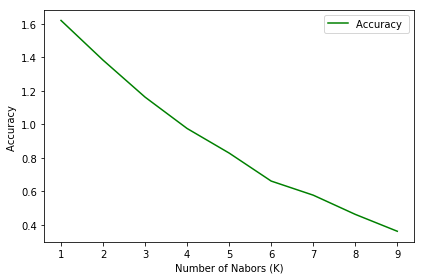

In [177]:
plt.plot(range(1,Ks),mean_acc,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [178]:
# set number of clusters to 6 based on elbow
kclusters = 6

mumbai_sub_grouped_clustering = mumbai_sub_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_sub_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 5, 5, 5, 4, 5, 1, 1, 1, 0])

In [179]:
# add clustering labels
mumbai_sub.insert(0, 'Cluster Labels', kmeans.labels_)
mumbai_sub


,Cluster Labels,WardArea,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Ward A - Colaba,18.920981,72.827472,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
1,5,Ward B - Sanhurst Road,18.956941,72.839720,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,5,Ward C - Marine Lines,18.951097,72.827200,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,5,Ward D - Grant Road,18.955231,72.808287,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
5,4,Ward F South - Parel,18.998980,72.853965,Bus Station,Train Station,Harbor / Marina,Flea Market,Breakfast Spot,Women's Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
8,5,Ward G North - Dadar/Plaza,19.030693,72.844038,Indian Restaurant,Movie Theater,Chinese Restaurant,Fast Food Restaurant,Department Store,Deli / Bodega,Beach,Bar,Sandwich Place,Fish Market
10,1,Ward H West - Bandra,19.062199,72.828466,Indian Restaurant,Café,Chinese Restaurant,Dessert Shop,Gym / Fitness Center,Arcade,Asian Restaurant,Bakery,Bar,Bookstore
11,1,Ward K East - Andheri (East),19.112184,72.869286,Hotel,Indian Restaurant,Multiplex,Vegetarian / Vegan Restaurant,Pizza Place,Department Store,Hotel Bar,Burger Joint,Diner,Cosmetics Shop
13,1,Ward L - Kurla,19.087801,72.885419,Café,Indian Restaurant,Coffee Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Restaurant,Dessert Shop,Beer Garden,Shopping Mall
14,0,Ward M East - Chembur East,19.044800,72.921606,Coffee Shop,Indian Restaurant,Café,Convenience Store,Food & Drink Shop,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio,French Restaurant


In [180]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_sub['Latitude'], mumbai_sub['Longitude'], mumbai_sub['WardArea'], mumbai_sub['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyze the clusters from this interation

### Cluster 0 - Eateries

In [133]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 0, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Ward M East - Chembur East,Coffee Shop,Indian Restaurant,Café,Convenience Store,Food & Drink Shop,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio,French Restaurant


### Cluster 1 - Restaurants and eateries

In [134]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 1, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ward A - Colaba,Indian Restaurant,Café,Diner,Coffee Shop,German Restaurant,Chaat Place,Cosmetics Shop,Middle Eastern Restaurant,Mediterranean Restaurant,Juice Bar
10,Ward H West - Bandra,Indian Restaurant,Café,Chinese Restaurant,Dessert Shop,Gym / Fitness Center,Arcade,Asian Restaurant,Bakery,Bar,Bookstore
11,Ward K East - Andheri (East),Hotel,Indian Restaurant,Multiplex,Vegetarian / Vegan Restaurant,Pizza Place,Department Store,Hotel Bar,Burger Joint,Diner,Cosmetics Shop
13,Ward L - Kurla,Café,Indian Restaurant,Coffee Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Restaurant,Dessert Shop,Beer Garden,Shopping Mall
17,Ward P South - Goregaon,Indian Restaurant,Smoke Shop,Chinese Restaurant,Dance Studio,Fast Food Restaurant,Breakfast Spot,Donut Shop,Cosmetics Shop,Cupcake Shop,Deli / Bodega
19,Ward R South - Kandivalli,Park,Moving Target,Café,Ice Cream Shop,Snack Place,Diner,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio
20,Ward R Central - Borivali West,Café,Restaurant,Indian Restaurant,Arcade,Chinese Restaurant,Fast Food Restaurant,Pub,Bus Station,Multiplex,Women's Store
23,Ward T - Mulund,Indian Restaurant,Pizza Place,Fast Food Restaurant,Clothing Store,Cosmetics Shop,Coffee Shop,Food Court,Mobile Phone Shop,Café,Shopping Mall


### Cluster 2 - Residential

In [135]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 2, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Ward N - Ghatkopar,Bus Station,Bank,Indian Restaurant,Lounge,Women's Store,Donut Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store


### Cluster 3 - Snacks and playground

In [136]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 3, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Ward R North - Dahiser,Juice Bar,Food Court,Chinese Restaurant,Playground,Bakery,Indian Restaurant,Diner,Women's Store,Cupcake Shop,Dance Studio


### Cluster 4 - Shopping

In [137]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 4, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Ward F South - Parel,Bus Station,Train Station,Harbor / Marina,Flea Market,Breakfast Spot,Women's Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio


### Cluster 5 - Restaurants and shopping

In [138]:
mumbai_sub.loc[mumbai_sub['Cluster Labels'] == 5, mumbai_sub.columns[[1] + list(range(4, mumbai_sub.shape[1]))]]

,WardArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ward B - Sanhurst Road,Indian Restaurant,Furniture / Home Store,Harbor / Marina,Sandwich Place,Smoke Shop,Convenience Store,Diner,Cosmetics Shop,Cupcake Shop,Dance Studio
2,Ward C - Marine Lines,Indian Restaurant,Women's Store,Multiplex,Food,Fast Food Restaurant,Bus Station,Jewelry Store,Diner,Cupcake Shop,Dance Studio
3,Ward D - Grant Road,Indian Restaurant,Coffee Shop,Park,Restaurant,Gastropub,Ice Cream Shop,Clothing Store,Food & Drink Shop,Theater,Bakery
8,Ward G North - Dadar/Plaza,Indian Restaurant,Movie Theater,Chinese Restaurant,Fast Food Restaurant,Department Store,Deli / Bodega,Beach,Bar,Sandwich Place,Fish Market
18,Ward P North - Malad,Coffee Shop,Clothing Store,Italian Restaurant,Bar,Shopping Mall,Café,Chinese Restaurant,Pub,Fast Food Restaurant,Multiplex
